In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/github/data-science/new_project

/content/drive/MyDrive/github/data-science/new_project


In [ ]:
!pip install scikit-learn

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset

from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

from nltk import flatten

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix

import seaborn as sns

import time
import joblib
import sklearn.metrics

from tqdm import tqdm

import statistics

In [ ]:
class HotelDataset(Dataset):
  def __init__(self, split='train'):
    """
    1. Load the data, e.g. df= pd.Feather load ()

    Data preprocessing:
    - Make sure fast indexing, so, maybe use guest_id as index
    - New time index, running from 1 (first time) ... last_time
    - Data needs to be all numerical, use encoders to encode data if needed before hand
    - Normalize data
    """
    self.scaled_df = pd.read_csv('output_other_dataset/df_original_data_standardscaler', index_col = [0,1])
    self.scaled_df.index = pd.MultiIndex.from_tuples([(str(x[0]), str(x[1])) for x in self.scaled_df.index])
    self.scaled_df = self.scaled_df.iloc[1:, :]
    missing_rows = self.scaled_df.isnull().any(axis = 1)
    self.scaled_df = self.scaled_df[~missing_rows]
    houses = self.scaled_df.index.get_level_values(0)
    self.house_idx = np.unique([houses[0]] + list(houses[1:].astype(int))) #TODO: Maybe add first row too
    self.split_indexes = self.train_test_split(split)
    self.y = pd.read_csv('output_other_dataset/y_original_data', index_col = [0,1])
    self.y = self.y[~missing_rows.values]
    return

  def train_test_split(self, split):
    np.random.seed(42)
    max_houses = len(self.house_idx)
    n = int(max_houses * 0.8)

    indexes = np.random.permutation(max_houses)

    if split == "train":
      return indexes[:n]
    elif split == "validation":
      return indexes[n:]

  def __len__(self):
    """
    np.unique(houses)
    """
    return len(self.split_indexes)

  def __getitem__(self, idx):
    """
    idx --> house_id
    self.df[idx]
    """

    idx = self.split_indexes[idx]
    chosen_house = self.scaled_df.loc[self.house_idx[idx]]
    y_house = self.y.loc[int(self.house_idx[idx])]
    y_array = y_house.to_numpy().squeeze(1)

    house_array = chosen_house.to_numpy()  # [sequence length, columns]

    cut_off = np.random.randint(1, house_array.shape[0]) if house_array.shape[0] > 1 else 1
    return house_array[:cut_off, :], y_array[cut_off -1]


In [ ]:
data_train = HotelDataset(split='train')
data_test = HotelDataset(split='validation')

<ipython-input-28-a4f79122d530>:12: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  self.scaled_df = pd.read_csv('output_other_dataset/df_original_data_standardscaler', index_col = [0,1])
<ipython-input-28-a4f79122d530>:12: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  self.scaled_df = pd.read_csv('output_other_dataset/df_original_data_standardscaler', index_col = [0,1])


**Getting the data ready for the test set**

In [ ]:
list_length = []
for i,data in enumerate(data_test):
  booking_seqs, labels = zip(data)
  seq_length = [len(booking) for booking in booking_seqs]
  # list_length.append(seq_length)
  if seq_length[0] < 79:
    list_length.append(seq_length)

In [ ]:

for value in max(list_length):
  max_value = value
# columns_x = list(range(1, (max_value* 28) + 1))
# X_test = pd.DataFrame(columns = columns_x)
X_test = []
y_test = []
for i,data in tqdm(enumerate(data_test), total=len(data_test)):
  booking_seqs, labels = zip(data)
  seq_length = [len(booking) for booking in booking_seqs]
  list_seqs = []
  if seq_length[0] < 79:
    added_data = 78 - seq_length[0]
    added_data_list = [-10] * (added_data * 6)
    seqs = [j for sub in booking_seqs for j in sub]
    for list_seq in seqs:
      list_seqs.extend(list_seq)
    list_seqs.extend(added_data_list)
    y_test.append(labels[0])
    X_test.append(list_seqs)

100%|██████████| 500/500 [00:00<00:00, 551.29it/s]


**Getting the data ready for the train set**

In [ ]:
list_length = []
for i,data in enumerate(data_train):
  booking_seqs, labels = zip(data)
  seq_length = [len(booking) for booking in booking_seqs]
  if seq_length[0] < 79:
    list_length.append(seq_length)

In [ ]:
for value in max(list_length):
  max_value = value
X_train = []
y_train = []
for i,data in tqdm(enumerate(data_train), total=len(data_train)):
  booking_seqs, labels = zip(data)
  seq_length = [len(booking) for booking in booking_seqs]
  list_seqs = []
  if seq_length[0] < 79:
    added_data = 78 - seq_length[0]
    added_data_list = [-10] * (added_data * 6)
    seqs = [j for sub in booking_seqs for j in sub]
    for list_seq in seqs:
      list_seqs.extend(list_seq)
    list_seqs.extend(added_data_list)
    y_train.append(labels[0])
    X_train.append(list_seqs)

100%|██████████| 2000/2000 [00:07<00:00, 257.66it/s]


In [ ]:
y_train = np.array(y_train)
not_1000 = y_train != -1000
X_train = np.array(X_train)

In [ ]:
rmse_list = []
mae_list = []
precision_list = []
recall_list = []
f1_list = []
time_list = []
for i in range(10):
  regr = RandomForestRegressor(max_depth = 3, n_estimators = 30)
  start_time = time.time()
  regr.fit(X_train[not_1000], (y_train[not_1000]))
  t = time.time() - start_time
  t = round(t)
  joblib.dump(regr, "Trained_models/rfr_model_finalDunnhumby_{0}_{1}.pkl".format(i, t))
  predicted_y = regr.predict(X_test)
  y_test = np.array(y_test)
  y_test_df = pd.DataFrame(y_test, columns = ["labels"])
  predicted_y_df = pd.DataFrame(predicted_y, columns = ["next_event"])
  df_old = pd.concat([y_test_df, predicted_y_df], axis = 1)
  df_old.columns = ["labels", "next_event"]
  df_sorted = df_old.copy()
  rmse = np.sqrt(mean_squared_error(df_sorted["labels"], df_sorted["next_event"]))
  mae = mean_absolute_error(df_sorted["labels"], df_sorted["next_event"])
  df_sorted["labels_label"] = 0
  df_sorted["next_event_label"] = 0
  for i in range(len(df_sorted)):
    if df_sorted["labels"][i] < 3:
      df_sorted["labels_label"][i] = 1
    elif 3 < df_sorted["labels"][i] < 7:
      df_sorted["labels_label"][i] = 2
    elif 7 < df_sorted["labels"][i] < 16:
      df_sorted["labels_label"][i] = 3
    else:
      df_sorted["labels_label"][i] = 4
    if df_sorted["next_event"][i] < 3:
      df_sorted["next_event_label"][i] = 1
    elif 3 < df_sorted["next_event"][i] < 7:
      df_sorted["next_event_label"][i] = 2
    elif 7 < df_sorted["next_event"][i] < 16:
      df_sorted["next_event_label"][i] = 3
    else:
      df_sorted["next_event_label"][i] = 4
  # print(df_sorted)
  rmse_list.append(rmse)
  mae_list.append(mae)
  precision_list.append(sklearn.metrics.precision_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro"))
  recall_list.append(sklearn.metrics.recall_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro"))
  f1_list.append(sklearn.metrics.f1_score(df_sorted["labels_label"], df_sorted["next_event_label"], average = "macro"))
  time_list.append(t)

<ipython-input-41-b724cb01be2a>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sorted["labels_label"][i] = 4
<ipython-input-41-b724cb01be2a>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sorted["next_event_label"][i] = 3
<ipython-input-41-b724cb01be2a>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sorted["labels_label"][i] = 1
<ipython-input-41-b724cb01be2a>:41: SettingWithCopyWarning: 
A value is trying to be set o

In [ ]:
print(np.mean(rmse_list))
print(np.mean(mae_list))
print(np.mean(precision_list))
print(np.mean(recall_list))
print(np.mean(f1_list))
print(np.mean(time_list))

1.0

**Evaluation metrics**

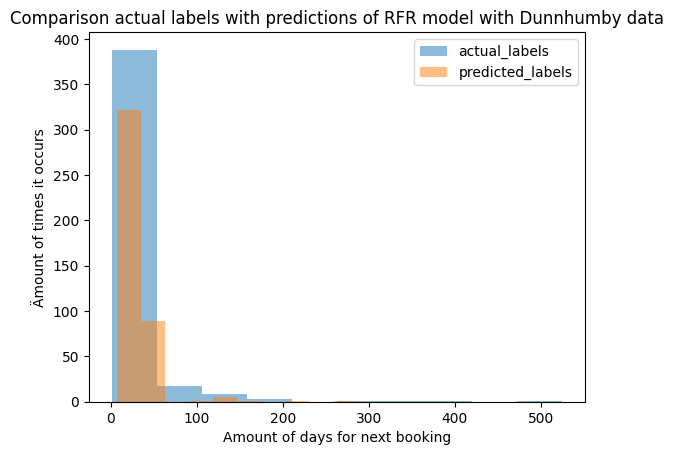

In [ ]:
plt.hist(df_sorted["labels"], alpha = 0.5, label ="actual_labels")
plt.hist(df_sorted["next_event"], alpha = 0.5, label ="predicted_labels")
plt.title("Comparison actual labels with predictions of RFR model with Dunnhumby data")
plt.xlabel("Amount of days for next booking")
plt.ylabel("Ämount of times it occurs")
# plt.xlim(0, 250)
plt.legend(prop ={'size': 10})

<ipython-input-49-2f734e505c80>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_sorted["labels"],hist = True, label ="labels", bins = 50)
<ipython-input-49-2f734e505c80>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_sorted["next_event"],hist = True, label ="predicted_labels", bins = 50

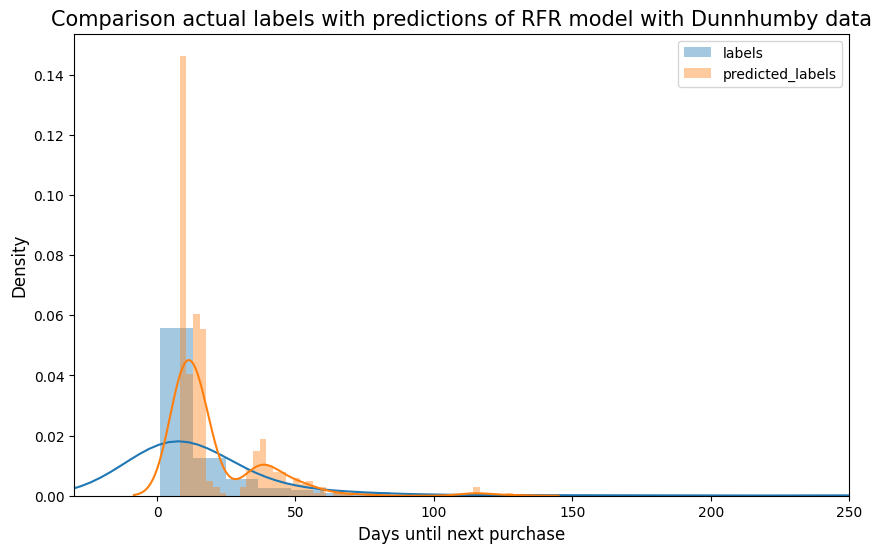

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df_sorted["labels"],hist = True, label ="labels", bins = 50)
sns.distplot(df_sorted["next_event"],hist = True, label ="predicted_labels", bins = 50)
plt.title("Comparison actual labels with predictions of RFR model with Dunnhumby data", size = 15)
plt.xlabel("Days until next purchase", size = 12)
plt.ylabel("Density", size = 12)
plt.xlim(-30,250)
plt.legend()

<ipython-input-51-554fd5016ffd>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_sorted["labels"] - df_sorted['next_event'],hist = True)


Text(0, 0.5, 'Density')

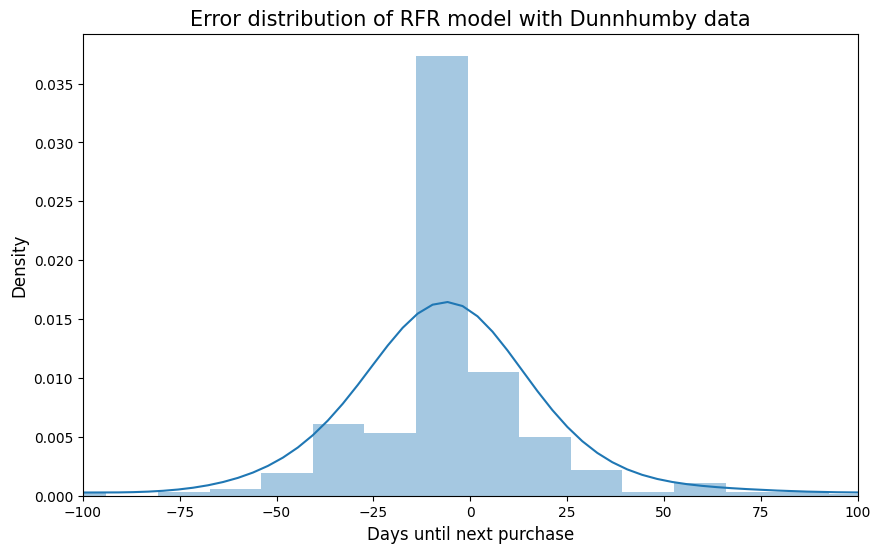

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(df_sorted["labels"] - df_sorted['next_event'],hist = True)
plt.title("Error distribution of RFR model with Dunnhumby data", size = 15)
plt.xlim(-100, 100)
plt.xlabel("Days until next purchase", size = 12)
plt.ylabel("Density", size = 12)

In [ ]:
cm = confusion_matrix(df_sorted["labels_label"], df_sorted["next_event_label"])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn, index = [1, 2, 3, 4], columns = [1,2,3,4])

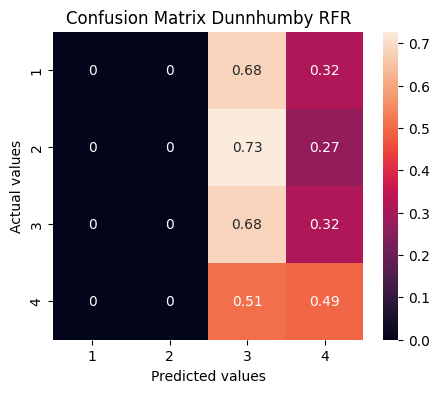

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot = True)
plt.title("Confusion Matrix Dunnhumby RFR")
plt.ylabel("Actual values")
plt.xlabel("Predicted values")
plt.show()